# [POC] Foetal Health Classification w Scikit-learn

This dataset contains **2126** records of features extracted from Cardiotocogram exams, which were then classified by three expert obstetritians into 3 classes:

1. Normal
2. Suspect
3. Pathological

The dataset is obtained from [Kaggle.com](https://www.kaggle.com/), an online machine learning community.

Link to the dataset is [Here](https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification?resource=download)

## 1. Importing Packages


In [17]:
# General Python imports
import os
import gc
import time
import tqdm
import random

os.environ['KERAS_BACKEND'] = 'tensorflow'

import numpy as np
import pandas as pd
from itertools import cycle

# Visualisation imports
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')     

# Machine Learning libraries
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [18]:
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        FILE_PATH = os.path.join(dirname, filename)
        print(FILE_PATH)

input/fetal_health.csv


## 2. Config

In [19]:
SEED = 123
random.seed(SEED)

TEST_SIZE = 0.20
VAL_SIZE = 0.15

EPOCHS = 100
BATCH_SIZE = 4

## 3. Data

### 3.1 Loading the Data

In [20]:
data = pd.read_csv(FILE_PATH)
data.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

In [22]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,133.303857,9.840844,106.0,126.000,133.000,140.000,160.000
accelerations,2126.0,0.003178,0.003866,0.0,0.000,0.002,0.006,0.019
fetal_movement,2126.0,0.009481,0.046666,0.0,0.000,0.000,0.003,0.481
uterine_contractions,2126.0,0.004366,0.002946,0.0,0.002,0.004,0.007,0.015
light_decelerations,2126.0,0.001889,0.002960,0.0,0.000,0.000,0.003,0.015
severe_decelerations,2126.0,0.000003,0.000057,0.0,0.000,0.000,0.000,0.001
prolongued_decelerations,2126.0,0.000159,0.000590,0.0,0.000,0.000,0.000,0.005
abnormal_short_term_variability,2126.0,46.990122,17.192814,12.0,32.000,49.000,61.000,87.000
mean_value_of_short_term_variability,2126.0,1.332785,0.883241,0.2,0.700,1.200,1.700,7.000
percentage_of_time_with_abnormal_long_term_variability,2126.0,9.846660,18.396880,0.0,0.000,0.000,11.000,91.000


### 3.2 Data Analysis

The analysis consist of:

* Count Plot
* Correlation Heat Map
* Implot
* Swarm And Boxen Plot

<Axes: xlabel='fetal_health', ylabel='count'>

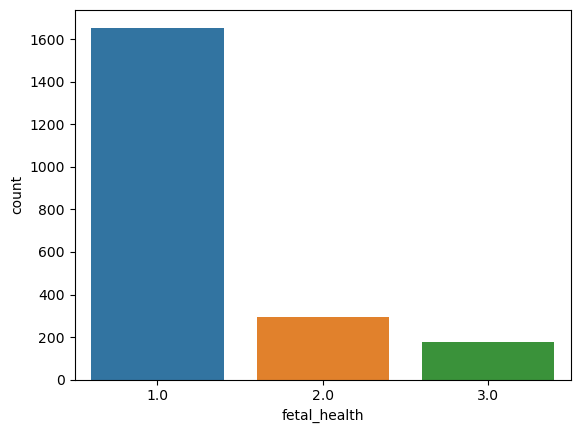

In [36]:
# To check if the data is imbalanced or not
sns.countplot(data=data, x="fetal_health")

The count plot of targets indicates an imbalance in data. This is a case that tends to provide misleading classification accuracy.


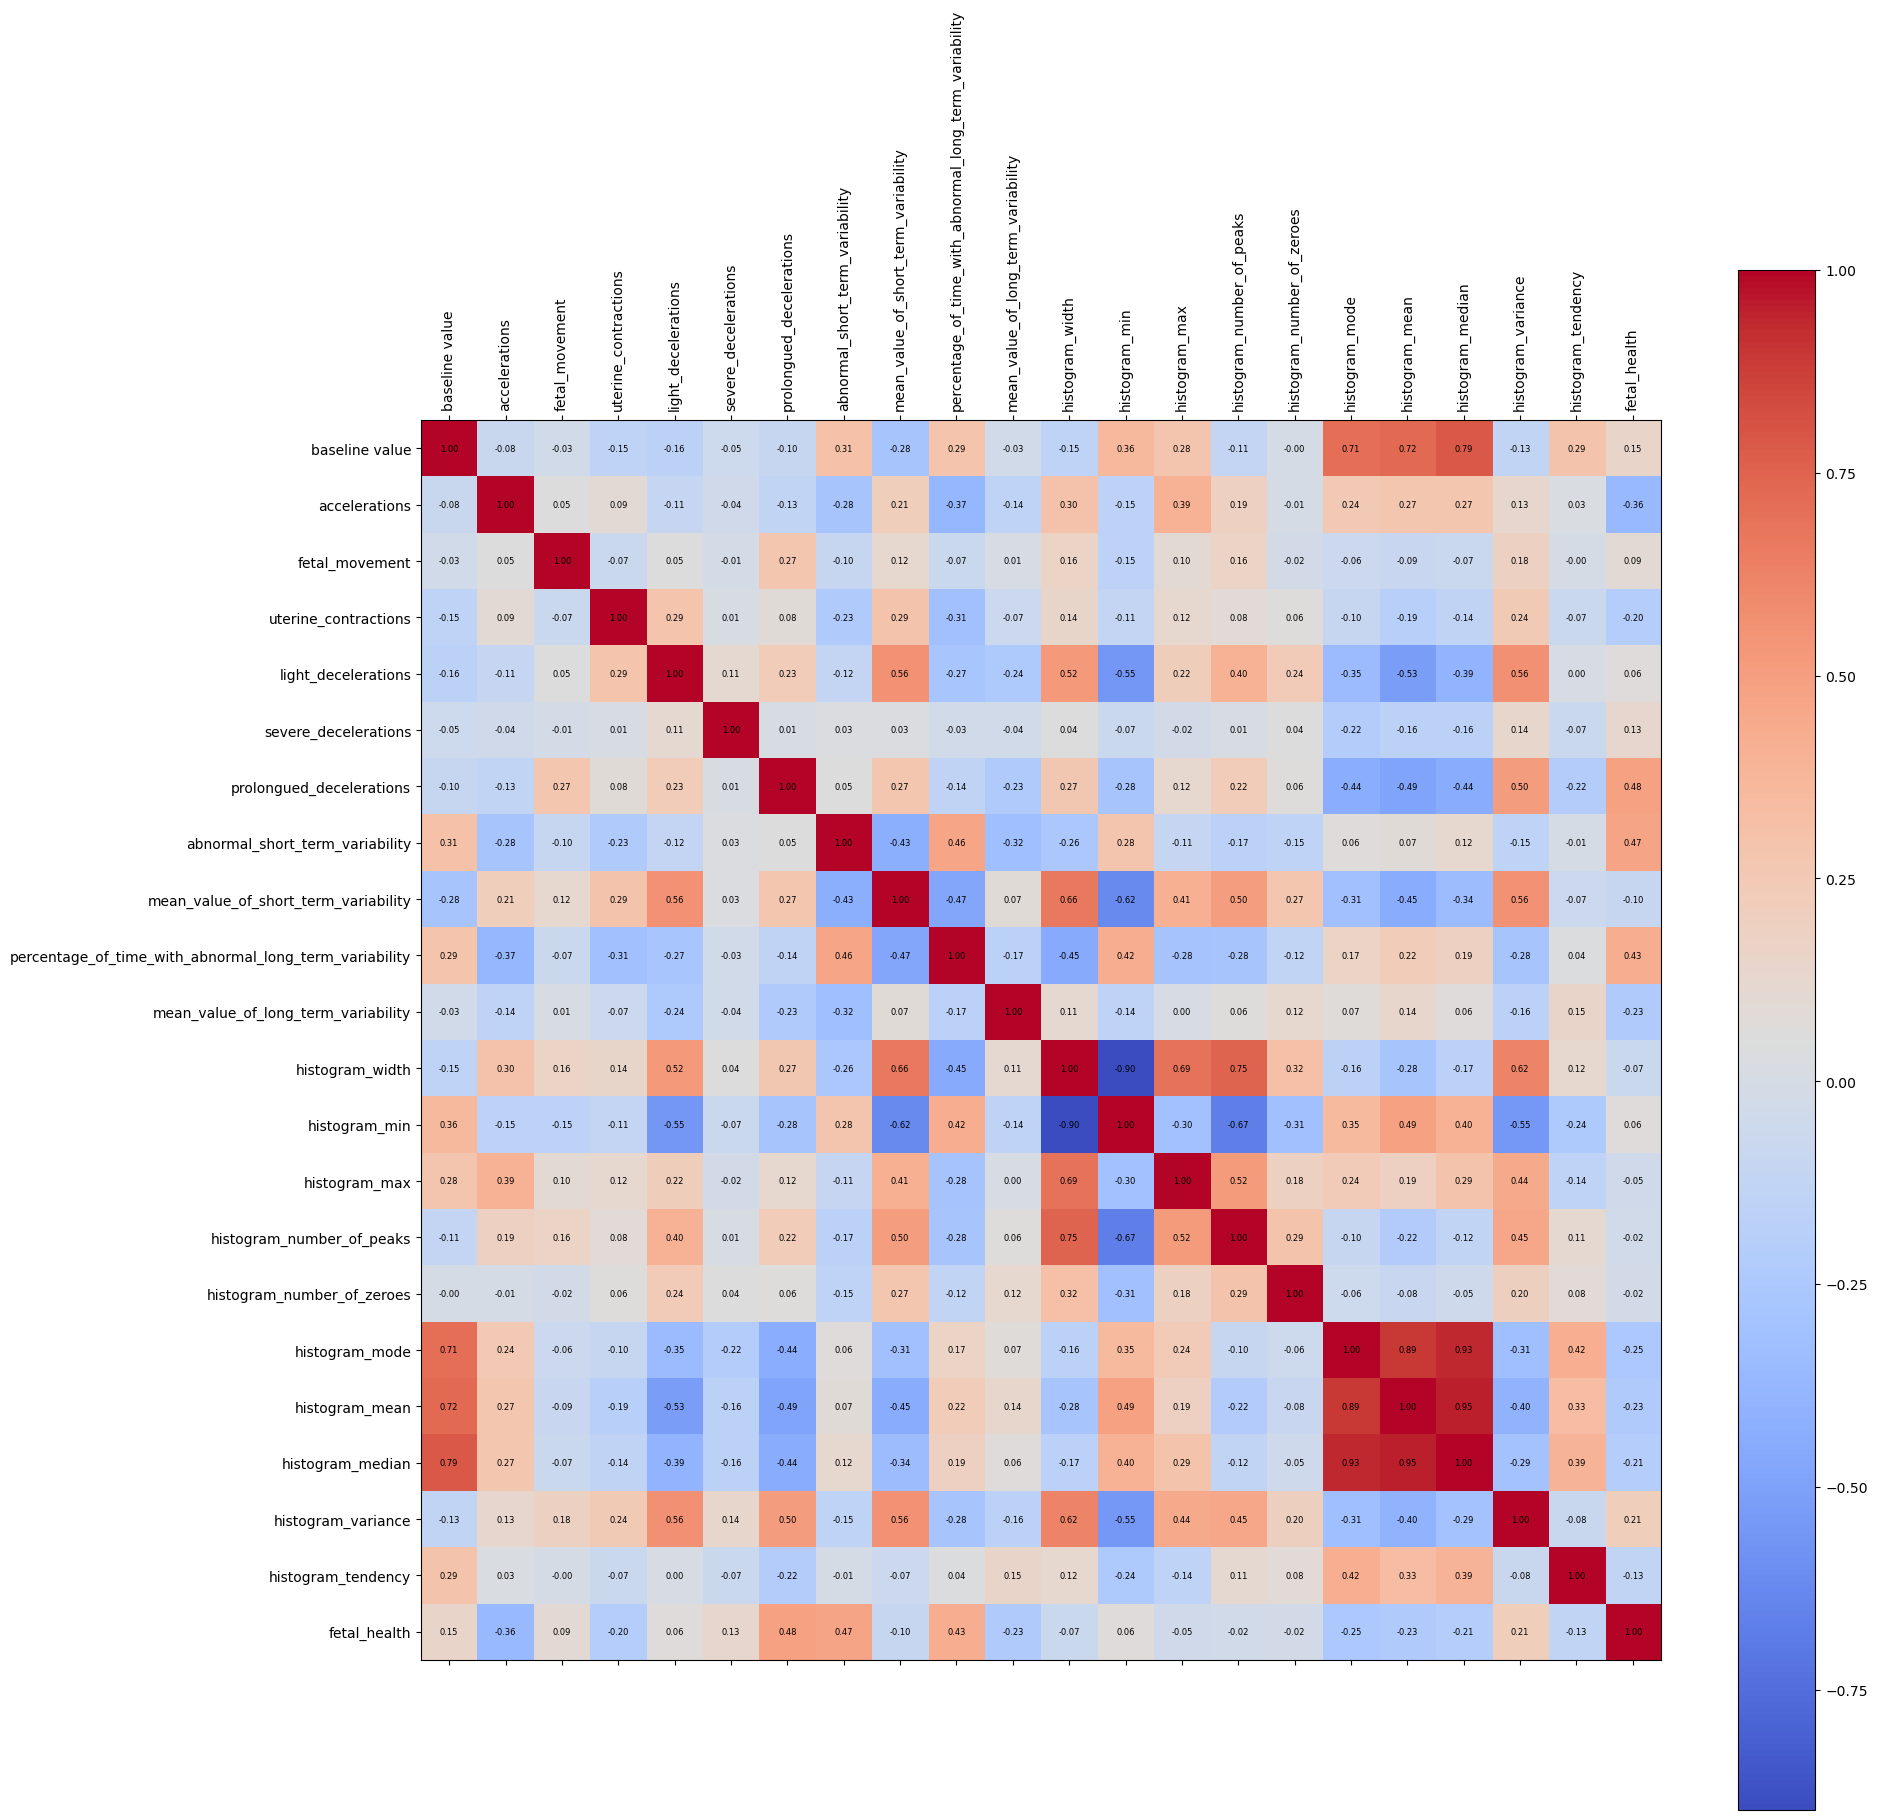

In [28]:
# Correlation matrix
corrmat= data.corr()

fig, ax = plt.subplots(figsize=(20, 20))
cax = ax.matshow(corrmat, cmap='coolwarm')
fig.colorbar(cax)
plt.xticks(range(len(corrmat.columns)), corrmat.columns, rotation=90)
plt.yticks(range(len(corrmat.columns)), corrmat.columns)

# Add the text annotations
for (i, j), val in np.ndenumerate(corrmat.values):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', fontsize=6)

plt.show()

Based on the correlation matix, we can infer that
1. "accelerations"
2. "prolongued_decelerations"
3. "abnormal_short_term_variability"
4. "percentage_of_time_with_abnormal_long_term_variability"

are the features with higher correlation with fetal_health.

### 3.3 Correlation with Fetal Movement and Fetal Health

**1. Accelerations**

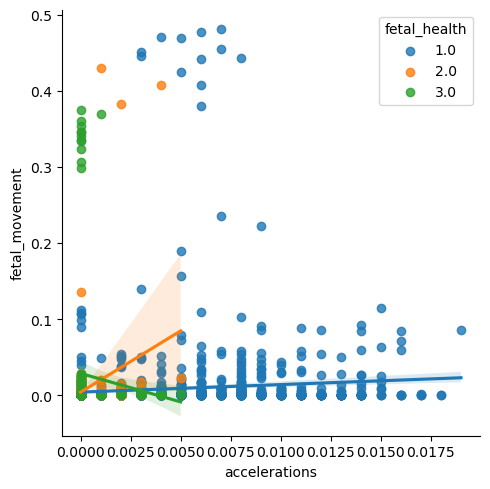

In [29]:
sns.lmplot(data=data,x="accelerations",y="fetal_movement", hue="fetal_health",legend_out=False)
plt.show()

**2. Prolonged Decelerations**

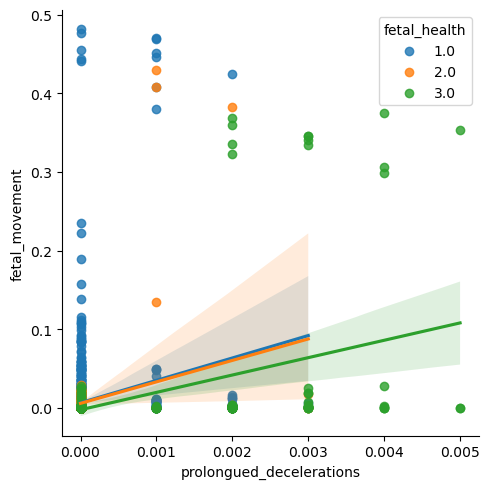

In [40]:
sns.lmplot(data =data,x="prolongued_decelerations",y="fetal_movement", hue="fetal_health",legend_out=False)
plt.show()

**3. Abnormal Short Term Variability**

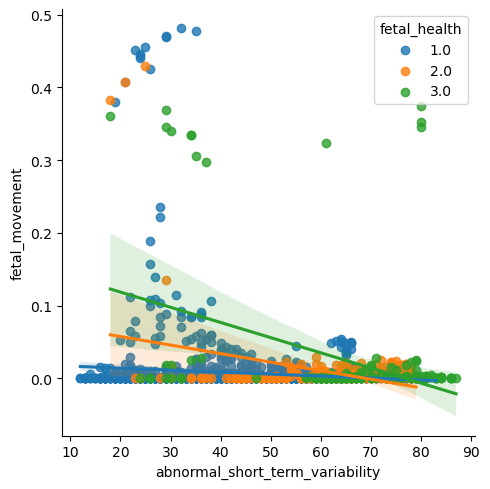

In [41]:
sns.lmplot(data =data,x="abnormal_short_term_variability",y="fetal_movement", hue="fetal_health",legend_out=False)
plt.show()